In [1]:
import pandas as pd
import numpy as np 

import geopandas as gpd
import shapely
import fiona
import folium

## Dataset

In [11]:
SHAPE_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/shape/Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales'
DATA_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/data_7days'

Importing output areas for spatial delimitation

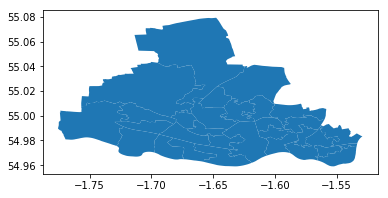

In [12]:
lsoa = gpd.read_file(SHAPE_FOLDER+'/Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales.shp')
lsoa = lsoa[lsoa['msoa11nm'].str.contains('Newcastle upon Tyne')]
lsoa = lsoa.to_crs(fiona.crs.from_epsg(4326))
lsoa.crs = {'init': 'epsg:4326', 'no_defs': True}

lsoa.plot()

Parsing metadata positions to geopandas/shapely geometries and filtering them by output areas

In [13]:
metadata = pd.read_csv(DATA_FOLDER+'/sensors.csv')

# spatial parsing - geometry column
metadata = gpd.GeoDataFrame(metadata[['name','type','active','lon','lat']],
                        geometry=[shapely.geometry.Point(xy) for xy in zip(metadata['lon'], metadata['lat'])], 
                        crs={'init': 'epsg:4326'}).to_crs(fiona.crs.from_epsg(4326))

metadata = gpd.sjoin(metadata, lsoa, how='inner' ,op='intersects')[['name','type','active','lon','lat','geometry']]
metadata = metadata.set_index('name')

metadata.shape

(147, 5)

Resampling sensors samples to a specific time frequency, acquiring medians to avoid outliers, and also samples inside output area

In [14]:
sensors = pd.read_csv(DATA_FOLDER+'/data.csv')
sensors['Timestamp'] = pd.to_datetime(sensors['Timestamp'])
sensors = sensors.set_index(['Variable','Sensor Name','Timestamp'])

# resampling by freq
freq='H'
level_values = sensors.index.get_level_values
sensors = (sensors.groupby([level_values(i) for i in [0,1]]
                   +[pd.Grouper(freq=freq, level=-1)]).median())

# filtering by Newcastle's region
m = metadata.index.values
s = sensors.reset_index()
s = s.loc[s['Sensor Name'].isin(m)]
sensors = s.set_index(['Variable','Sensor Name','Timestamp'])

sensors.reset_index()['Sensor Name'].unique().shape

(147,)

Reducing metadata and sensors dataframes to consider less variables

In [15]:
variables = ['CO', 'Humidity', 'Journey Time', 'NO2', 'O3', 
             'PM10', 'Particle Count', 'Sound', 'Temperature', 
             'Wind Direction', 'Wind Speed']
# variables = ['NO2', 'O3', 'Temperature']

sensors = sensors.loc[variables]
metadata = metadata.loc[sensors.index.get_level_values(1).unique()]

## Feature ingestion

This consider a list of k neighbors measures for each time and variable, to predict a single target specified

In [17]:
def ingestion(sensors, metadata, variables, k, target):
    idx = pd.IndexSlice
    zi = sensors.loc[target]
    zx = pd.DataFrame()
    for s in sensors.index.get_level_values(1).unique():
        i = metadata.loc[s]
#         print('for sensor {}'.format(i.name))

        for t in sensors.index.get_level_values(2).unique():
    #         print('-- for timestamp {}'.format(t))
            zkj = pd.DataFrame()
            zk = pd.DataFrame()
            zk['timestamp'] = [t]*k
            zk['zi'] = [i.name]*k
            zk['Sensor Name'] = range(0,k)
            zk.set_index(['zi','timestamp','Sensor Name'],inplace=True)

            for var in variables:

                sdf = sensors.loc[idx[var,:,t],:] # sensors of the var variable at  time t 
                mdf = metadata.loc[sdf.index.get_level_values(1).unique()] # metadata about them

                dij = mdf['geometry'].apply(lambda x: i['geometry'].distance(x)).sort_values() # nearest measures for (var,t)
                dij = dij.loc[(dij.index!=i.name) & (dij>0)][:k] # excluding the sensor i

                zj = sdf.loc[idx[:,dij.index,:],:].reset_index([0,2])['Value']
                zj.name = var

                zj.index = range(0,k)
                dij.index = range(0,k)

                zk.loc[idx[i.name,t],'d_{}'.format(var)] = dij.values
                zk.loc[idx[i.name,t],var] = zj.values
                zkj = zk.melt().set_index('variable').T
                zkj.index = [t]
                zkj['zi'] = i.name
                zkj = zkj.reset_index().set_index(['zi','index'])
            zx = zx.append(zkj)
    zx['day'] = zx.index.get_level_values(1).day
    zx['hour'] = zx.index.get_level_values(1).hour
    zx['month'] = zx.index.get_level_values(1).month

    zx = zx.loc[zi.index]
    zi = zi.loc[idx[zx.index.get_level_values(0).unique(),zx.index.get_level_values(1).unique()],:]

    return zx, zi

In [ ]:
zx, zi = ingestion(sensors, metadata, variables=['NO2','O3','Humidity'], k=3, target='NO2')
print(zx.shape)
print(zi.shape)
zx.head()

In [ ]:
# to_csv

## Regression example

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()

paramsrf = {
    'n_estimators':np.arange(5,100,5),
    'max_features':np.arange(0.1, 1.01, 0.05),
    'max_depth':np.arange(1,10,1)
}
grid = RandomizedSearchCV(rf, param_distributions=paramsrf,
                    n_iter=500, scoring='r2', n_jobs=-1, cv=5).fit(zx.values, np.ravel(zi.values))
grid.best_score_

-0.6539857450423097

## Feature importance analysis

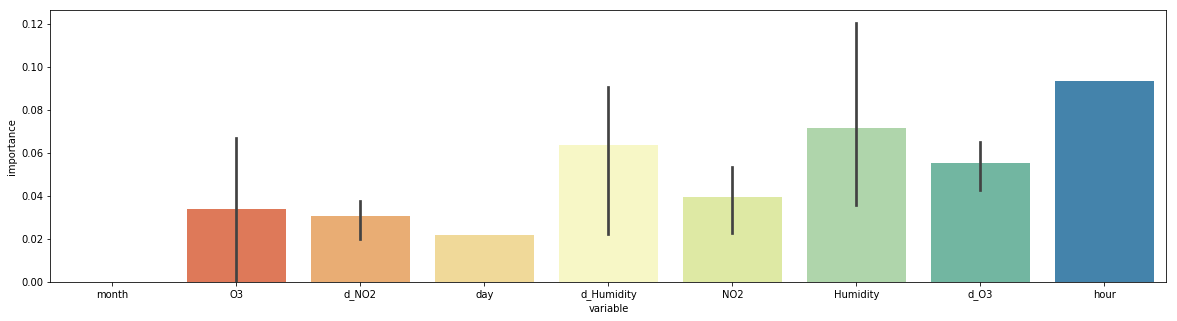

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

importances = grid.best_estimator_.feature_importances_
indices = zx.columns[np.argsort(importances)[::-1]]
f = pd.DataFrame(importances, index=indices, columns=['importance']).reset_index().sort_values('importance')

plt.figure(figsize=(20,5))
sns.barplot(x='variable',y='importance',data=f, palette='Spectral')